In [1]:
# Required to setup DB and consume GTFS static data
import mysql.connector
from mysql.connector import Error
from mysql.connector import errorcode
from mysql.connector.constants import ClientFlag
import os
import csv
from datetime import datetime
from time import time, sleep

STATIC_CSV = "static_.csv"
DB_CSV = "db_.csv"

In [2]:
def executeScriptsFromFile(filename, cursor):
    # Open and read the file as a single buffer
    fd = open(filename, 'r')
    sqlFile = fd.read()
    fd.close()

    # all SQL commands (split on ';')
    sqlCommands = sqlFile.split(';')

    # Execute every command from the input file
    for command in sqlCommands:
        # This will skip and report errors
        # For example, if the tables do not yet exist, this will skip over
        # the DROP TABLE commands
        try:
            cursor.execute(command)
        except mysql.connector.Error as error:
            print("Error occurred while executing script : ", error)

In [3]:
## Create Tables and Indexes

def db_setup(filepath, tab=True, idx=False):
    connection = mysql.connector.connect(host='localhost', user='root', password='admin')
    try:
        cursor = connection.cursor()
        print("FILEPATH received : ", filepath)
        createtab_file = filepath + "create-tables.sql"
        createidx_file = filepath + "create-index.sql"
        
        if(tab):
            executeScriptsFromFile(createtab_file, cursor)
            print("TABLES CREATED ...")
            connection.commit()
        
        if(idx):
            executeScriptsFromFile(createidx_file, cursor)
            print("INDEXES CREATED ...")
            connection.commit()
    
    except mysql.connector.Error as error:
        connection.rollback() #rollback if any exception occured
        print("The following error has occurred ... ".format(error))

    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
            print("DB Setup complete. MySQL connection is closed.")

In [4]:
def all_tables(path, folder, date):
    filepath = "\'" + path + folder + "/"
    
    # Agency
    filename = "agency.txt'"
    tablename = "gtfs.agency"
    print(filepath)
    print(filename)
    print(tablename)
    bulk_ins(filepath, filename, tablename)
    
    # Calendar_Dates
    filename = "calendar_dates.txt'"
    tablename = "gtfs.calendar_dates"
    bulk_ins(filepath, filename, tablename)
    
    # Routes
    filename = "routes.txt'"
    tablename = "gtfs.routes"
    bulk_ins(filepath, filename, tablename)
    
    # Shapes
    filename = "shapes.txt'"
    tablename = "gtfs.shapes"
    bulk_ins(filepath, filename, tablename)
    
    # Stop_Times
    filename = "stop_times.txt'"
    tablename = "gtfs.stop_times"
    bulk_ins(filepath, filename, tablename)
    
    #Stops
    filename = "stops.txt'"
    tablename = "gtfs.stops"
    bulk_ins(filepath, filename, tablename)
    
    #Transfers
    filename = "transfers.txt'"
    tablename = "gtfs.transfers"
    bulk_ins(filepath, filename, tablename)
    
    #Trips
    filename = "trips.txt'"
    tablename = "gtfs.trips"
    bulk_ins(filepath, filename, tablename, date)

In [5]:
def bulk_ins(filepath, filename, tablename, date=None):
    try:
        connection = mysql.connector.connect(host='localhost', database='gtfs', user='root', \
                                             password='admin', client_flags=[ClientFlag.LOCAL_FILES])
        print("Connected to DB ...", ClientFlag.LOCAL_FILES)
        
        # Create cursor and execute Load SQL
        autoc_sql = "SET autocommit=0;"
        ucheck_sql = "SET unique_checks=0;"
        fcheck_sql = "set foreign_key_checks=0;"
        logcheck_sql = "set sql_log_bin=0;"
        
        load_sql = ("LOAD DATA LOCAL INFILE " + filepath + filename +
                    " INTO TABLE " + tablename +
                    " FIELDS TERMINATED BY ','"
                    " OPTIONALLY ENCLOSED BY '\"'"
                    " LINES TERMINATED BY '\\n'"
                    " IGNORE 1 LINES")
        
        # INSERT DATE IN TABLES STOP_TIMES AND TRIPS
#         if(tablename == "gtfs.stop_times" or tablename == "gtfs.trips"):
        if(tablename == "gtfs.trips"):
            print("DATE VALUE RECEIVED ... ", date)
            load_sql = load_sql + " SET trip_date = '" + str(date) + "';"
        else:
            load_sql = load_sql + ";"
        
        cursor = connection.cursor()
        print("BULK INS ... ")
        print("FILEPATH received : ", filepath.strip('\''))
        print(filepath + filename)
        print(load_sql)
        
        cursor.execute(autoc_sql)
        cursor.execute(ucheck_sql)
        cursor.execute(fcheck_sql)
        cursor.execute(logcheck_sql)
        
        cursor.execute(load_sql)
        connection.commit()
        print("Succuessfully loaded the table " + tablename + " from " + filename.strip('\'') + " ... ")
    
    except mysql.connector.Error as error :
        print(cursor.statement)
        connection.rollback() #rollback if any exception occured
        print("Failed inserting record into table " + tablename + " from " + filename.strip('\'') + " ... {}".format(error))
        
    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
            print("MySQL connection is closed")

In [6]:
def main():

    # FETCH FILES
    # READS TWO CSV FILES FROM THE CURRENT WORKING DIRECTORY
    # DB_CSV PROVIDES THE PATH WHERE THE TABLE AND INDEX CREATION SCRIPTS ARE KEPT
    # STATIC_CSV PROVIDES THE PATH WHERE THE UNZIPPED STATIC DATA IS KEPT
    cwd = os.getcwd()
    db_csv = cwd.replace("\\", "/") + "/" + DB_CSV
    static_csv = cwd.replace("\\", "/") + "/" + STATIC_CSV
    
#     # GET DB SCRIPTS PATH
#     db_scripts = ""
#     with open(db_csv, "r") as file:
#         next(file)
#         for row in file:
#             db_scripts = row.strip().replace("\\", "/") + "/"
    
#     # SETUP DB
#     db_setup(db_scripts, tab=True, idx=False)
    
#     # DUMP DATA TO DB
#     dataset_path = ""
#     folder_name = ""
#     folder_date = ""
#     with open(static_csv, "r") as file:
#         next(file)
#         for row in file:
#             row = row.strip().split(",")
#             dataset_path = row[0].replace("\\", "/") + "/"
#             folder_name = row[1]
#             folder_date = row[2]
#             all_tables(dataset_path, folder_name, folder_date)
    
if __name__ == "__main__":
    main()

In [8]:
# Segregate Index Creation for the DB as it takes up a lot of time
# Run after all data has been inserted

# # FETCH FILES
# cwd = os.getcwd()
# db_csv = cwd.replace("\\", "/") + "/" + DB_CSV
# static_csv = cwd.replace("\\", "/") + "/" + STATIC_CSV

# # GET DB SCRIPTS PATH
# db_scripts = ""
# with open(db_csv, "r") as file:
#     next(file)
#     for row in file:
#         db_scripts = row.strip().replace("\\", "/") + "/"
# db_setup(db_scripts, tab=False, idx=True)

FILEPATH received :  C:/Users/kakka/Documents/GTFS_/code/
INDEXES CREATED ...
DB Setup complete. MySQL connection is closed.


In [7]:
# Generate a set of usable trip and service ids from the DB
def push_routes(filepath):
    try:
        connection = mysql.connector.connect(host='localhost', database='gtfs', user='root', \
                                             password='admin', client_flags=[ClientFlag.LOCAL_FILES])
        print("Connected to DB ...", ClientFlag.LOCAL_FILES)
        
        #
#         sel_sql = ( " SELECT DISTINCT ROUTE_SHORT_NAME, "
#                 " CASE ROUTE_TYPE "
#                 " WHEN '0' THEN 'TRAM'"
#                 " WHEN '1' THEN 'SUBWAY'"
#                 " WHEN '2' THEN 'RAIL'"
#                 " WHEN '3' THEN 'BUS'"
#                 " WHEN '4' THEN 'FERRY'"
#                 " END AS ROUTE_TYPE"
#                 " FROM GTFS.ROUTES ORDER BY ABS(ROUTE_SHORT_NAME), ROUTE_TYPE;" )
        
        sel_sql = ( " SELECT DISTINCT R.ROUTE_SHORT_NAME,"
                    " CASE R.ROUTE_TYPE "
                    " WHEN '0' THEN 'TRAM'"
                    " WHEN '1' THEN 'SUBWAY'"
                    " WHEN '2' THEN 'RAIL'"
                    " WHEN '3' THEN 'BUS'"
                    " WHEN '4' THEN 'FERRY'"
                    " END AS ROUTE_TYPE"
                    " FROM GTFS.ROUTES R, GTFS.TRIPS T"
                    " WHERE R.ROUTE_ID = T.ROUTE_ID"
                    " AND T.TRIP_ID IN ("
                    " SELECT DISTINCT ST.TRIP_ID"
                    " FROM GTFS.STOP_TIMES ST, GTFS.STOPS S"
                    " WHERE ST.STOP_ID = S.STOP_ID"
                    " AND UPPER(S.STOP_NAME) LIKE '%AMSTERDAM,%'"
                    " AND S.STOP_ID NOT LIKE '%stoparea%');" )
        
        cursor = connection.cursor()
        print("push_routes() ... ")
        print("FILEPATH received : ", filepath)
        print(sel_sql)
        cursor.execute(sel_sql)
        all_rows = cursor.fetchall()
        
        with open(filepath + 'routes_list.csv', 'w') as myfile:
            for row in all_rows:
                myfile.write(row[0] + "," + row[1] + "\n")
            print("Data write success ... ")
            print("Please check CSV file ROUTES.CSV at " + filepath)
            
#         with open(filepath + 'routes_list.csv', 'w') as myfile:
#             wr = csv.writer(myfile)
#             for row in all_rows:
#                 wr.writerow(row)
#             print("Data write success ... ")
#             print("Please check CSV file ROUTES.CSV at " + filepath)
    
    except mysql.connector.Error as error :
        print(cursor.statement)
        connection.rollback() #rollback if any exception occured
        print("Failed fetching data from GTFS.ROUTES ... {}".format(error))
        
    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
            print("MySQL connection is closed")

In [28]:
# GENERATE ROUTE DETAILS FOR USER
# cwd = os.getcwd()
# print(cwd)
# push_routes(cwd.replace("\\", "/") + "/")

C:\Users\kakka\Documents\GTFS_\code
Connected to DB ... 128
push_routes() ... 
FILEPATH received :  C:/Users/kakka/Documents/GTFS_/code/
 SELECT DISTINCT R.ROUTE_SHORT_NAME, CASE R.ROUTE_TYPE  WHEN '0' THEN 'TRAM' WHEN '1' THEN 'SUBWAY' WHEN '2' THEN 'RAIL' WHEN '3' THEN 'BUS' WHEN '4' THEN 'FERRY' END AS ROUTE_TYPE FROM GTFS.ROUTES R, GTFS.TRIPS T WHERE R.ROUTE_ID = T.ROUTE_ID AND T.TRIP_ID IN ( SELECT DISTINCT ST.TRIP_ID FROM GTFS.STOP_TIMES ST, GTFS.STOPS S WHERE ST.STOP_ID = S.STOP_ID AND UPPER(S.STOP_NAME) LIKE '%AMSTERDAM,%' AND S.STOP_ID NOT LIKE '%stoparea%');
Data write success ... 
Please check CSV file ROUTES.CSV at C:/Users/kakka/Documents/GTFS_/code/
MySQL connection is closed


In [7]:
# Required to parse GTFS real-time feed
from google.transit import gtfs_realtime_pb2
import requests

In [8]:
# READ THE SET OF TRANSIT LINES FOR WHICH THE USER WANTS TO EXTRACT STOP TIME DETAILS
def read_userpref(filepath):
    try:
        connection = mysql.connector.connect(host='localhost', database='gtfs', user='root', \
                                             password='admin', client_flags=[ClientFlag.LOCAL_FILES])
        print("Connected to DB ...", ClientFlag.LOCAL_FILES)
        
        # Open and read the file as a single buffer
        fd = open(filepath + 'user_routes.csv', 'r')
        usrFile = fd.read()
        fd.close()
        
        lines = usrFile.split("\n")
        print(lines)
        
        routes = []

        sel_sql = (" SELECT DISTINCT ROUTE_ID, ROUTE_TYPE, ROUTE_SHORT_NAME"
                   " FROM GTFS.ROUTES"
                   " WHERE ROUTE_TYPE = %s"
                   " AND ROUTE_SHORT_NAME = %s"
                   " AND AGENCY_ID = 'GVB'"
                   " ORDER BY ROUTE_ID;")
        
        cursor = connection.cursor()
        print("read_userpref() ... ")
        print("FILEPATH received : ", filepath)
        print(sel_sql)
        
        for line in lines:
            line = line.split(',')
            print(line)
            # REVERSE MAP ROUTE TYPE
#             " WHEN '0' THEN 'TRAM'"
#             " WHEN '1' THEN 'SUBWAY'"
#             " WHEN '2' THEN 'RAIL'"
#             " WHEN '3' THEN 'BUS'"
#             " WHEN '4' THEN 'FERRY'"
            if line[1] == 'TRAM':
                line[1] = 0
            elif line[1] == 'SUBWAY':
                line[1] = 1
            elif line[1] == 'RAIL':
                line[1] = 2
            elif line[1] == 'BUS':
                line[1] = 3
            elif line[1] == 'FERRY':
                line[1] = 4
            cursor.execute(sel_sql, (line[1], line[0]))
            routes.append([r for r in cursor.fetchall()])
            
        return routes
    
    except mysql.connector.Error as error :
        print(cursor.statement)
        connection.rollback() #rollback if any exception occured
        print("Failed inserting record into table " + tablename + " from " + filename + " ... {}".format(error))
        
    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
#             print("MySQL connection is closed")

In [9]:
# INSERT REALTIME DATA TO DB
def insert_rtdata(trip_updates):
    try:
        connection = mysql.connector.connect(host='localhost', database='gtfs', user='root', password='admin')
        cursor = connection.cursor()
        tu_query = """ INSERT INTO GTFS.trip_updates
                        (entity_id, route_id, route_short_name, route_type, trip_id, direction_id, start_date, start_time,
                        stop_sequence, stop_id, arrival_time, arrival_delay, departure_time, departure_delay, fetch_time)
                        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);"""
        # INCREASE PACKET SIZE TO BULK INSERT DATA
        packet_sql = 'SET GLOBAL max_allowed_packet=256*1024*1024'
        cursor.execute(packet_sql)
        result  = cursor.executemany(tu_query, trip_updates)
        connection.commit()
#         print("Record inserted successfully into GTFS.trip_updates table ... ")
        
    except mysql.connector.Error as error :
        connection.rollback() #rollback if any exception occured
        print("Failed inserting record into GTFS.trip_updates table ... {}".format(error))

    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
#             print("MySQL connection is closed ... ")

In [10]:
def parse_gtfsrt(user_routes):
    all_tus = []
    feed = gtfs_realtime_pb2.FeedMessage()
    response = requests.get('http://gtfs.ovapi.nl/nl/tripUpdates.pb')

    if(response.status_code == 200):
        feed.ParseFromString(response.content)
        ts = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        for entity in feed.entity:
          if entity.HasField('trip_update'):
            for ur in user_routes:
                for u in ur:
                    if(entity.trip_update.trip.route_id == str(u[0])):
#                         print("entity.id --- ", entity.id)
                        for x in entity.trip_update.stop_time_update:
                            all_tus.append((entity.id, entity.trip_update.trip.route_id, u[2], u[1], entity.trip_update.trip.trip_id, \
                                            entity.trip_update.trip.direction_id, entity.trip_update.trip.start_date, \
                                            entity.trip_update.trip.start_time, x.stop_sequence, x.stop_id, x.arrival.time, \
                                            x.arrival.delay, x.departure.time, x.departure.delay, ts))
    else:
        print("ERROR FETCHING REALTIME DATA FROM THE gtfs.ovapi.nl server")
        print(response.reason)

    print(len(all_tus))
    insert_rtdata(all_tus)

In [7]:
RETRIEVAL_FREQ = 60
RETRIEVAL_TIME = 60 * 24 * 7

In [ ]:
# Read User Input for lines from a CSV and FETCH THE CORRESPONDING TRIP UPDATE DETAILS FROM THE REALTIME FEED, and INSERT TO DB

cwd = os.getcwd()
print(cwd)
user_routes = read_userpref(cwd.replace("\\", "/") + "/")
print(user_routes)

starttime = time()
counter = 0
print("STARTTIME ... ", starttime)
while counter < RETRIEVAL_TIME:
#     print("TICK TOCK ... ")
    parse_gtfsrt(user_routes)
    counter = counter + 1
    print("DONE COUNT ... ", counter, " ... ", time(), " ... ", datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    sleep(RETRIEVAL_FREQ - ((time() - starttime) % RETRIEVAL_FREQ))

C:\Users\kakka\Documents\GTFS_\code
Connected to DB ... 128
['54,SUBWAY', '51,SUBWAY', '24,TRAM', '4,TRAM', '281,BUS', '22,BUS', '901,FERRY', '907,FERRY']
read_userpref() ... 
FILEPATH received :  C:/Users/kakka/Documents/GTFS_/code/
 SELECT DISTINCT ROUTE_ID, ROUTE_TYPE, ROUTE_SHORT_NAME FROM GTFS.ROUTES WHERE ROUTE_TYPE = %s AND ROUTE_SHORT_NAME = %s AND AGENCY_ID = 'GVB' ORDER BY ROUTE_ID;
['54', 'SUBWAY']
['51', 'SUBWAY']
['24', 'TRAM']
['4', 'TRAM']
['281', 'BUS']
['22', 'BUS']
['901', 'FERRY']
['907', 'FERRY']
[[(468, 1, '54')], [(481, 1, '51'), (63198, 1, '51')], [(49928, 0, '24')], [(61617, 0, '4')], [(60668, 3, '281')], [(60659, 3, '22')], [(491, 4, '901')], [(486, 4, '907')]]
STARTTIME ...  1550249436.817089
608
DONE COUNT ...  1  ...  1550249445.2511895  ...  2019-02-15 17:50:45
611
DONE COUNT ...  2  ...  1550249503.5238154  ...  2019-02-15 17:51:43
618
DONE COUNT ...  3  ...  1550249564.5572677  ...  2019-02-15 17:52:44
573
DONE COUNT ...  4  ...  1550249624.5028758  ...  

408
DONE COUNT ...  103  ...  1550255561.3365622  ...  2019-02-15 19:32:41
396
DONE COUNT ...  104  ...  1550255621.016295  ...  2019-02-15 19:33:41
395
DONE COUNT ...  105  ...  1550255681.3364956  ...  2019-02-15 19:34:41
404
DONE COUNT ...  106  ...  1550255741.1663013  ...  2019-02-15 19:35:41
433
DONE COUNT ...  107  ...  1550255801.265976  ...  2019-02-15 19:36:41
414
DONE COUNT ...  108  ...  1550255861.177012  ...  2019-02-15 19:37:41
419
DONE COUNT ...  109  ...  1550255921.0608852  ...  2019-02-15 19:38:41
427
DONE COUNT ...  110  ...  1550255987.0556474  ...  2019-02-15 19:39:47
427
DONE COUNT ...  111  ...  1550256041.4498508  ...  2019-02-15 19:40:41
424
DONE COUNT ...  112  ...  1550256101.164654  ...  2019-02-15 19:41:41
440
DONE COUNT ...  113  ...  1550256161.1456907  ...  2019-02-15 19:42:41
431
DONE COUNT ...  114  ...  1550256221.3709223  ...  2019-02-15 19:43:41
425
DONE COUNT ...  115  ...  1550256281.4258287  ...  2019-02-15 19:44:41
416
DONE COUNT ...  116  ... 

329
DONE COUNT ...  213  ...  1550262159.694712  ...  2019-02-15 21:22:39
341
DONE COUNT ...  214  ...  1550262219.7270048  ...  2019-02-15 21:23:39
323
DONE COUNT ...  215  ...  1550262279.9170074  ...  2019-02-15 21:24:39
324
DONE COUNT ...  216  ...  1550262339.686804  ...  2019-02-15 21:25:39
341
DONE COUNT ...  217  ...  1550262399.7733562  ...  2019-02-15 21:26:39
355
DONE COUNT ...  218  ...  1550262459.8882792  ...  2019-02-15 21:27:39
338
DONE COUNT ...  219  ...  1550262519.721419  ...  2019-02-15 21:28:39
339
DONE COUNT ...  220  ...  1550262579.783514  ...  2019-02-15 21:29:39
362
DONE COUNT ...  221  ...  1550262639.598237  ...  2019-02-15 21:30:39
344
DONE COUNT ...  222  ...  1550262699.9030871  ...  2019-02-15 21:31:39
326
DONE COUNT ...  223  ...  1550262759.7081985  ...  2019-02-15 21:32:39
326
DONE COUNT ...  224  ...  1550262819.698068  ...  2019-02-15 21:33:39
319
DONE COUNT ...  225  ...  1550262879.5480323  ...  2019-02-15 21:34:39
330
DONE COUNT ...  226  ...  1

317
DONE COUNT ...  323  ...  1550268759.0504336  ...  2019-02-15 23:12:39
302
DONE COUNT ...  324  ...  1550268819.0629697  ...  2019-02-15 23:13:39
279
DONE COUNT ...  325  ...  1550268879.2895305  ...  2019-02-15 23:14:39
278
DONE COUNT ...  326  ...  1550268939.1185548  ...  2019-02-15 23:15:39
267
DONE COUNT ...  327  ...  1550268999.180287  ...  2019-02-15 23:16:39
264
DONE COUNT ...  328  ...  1550269059.2921937  ...  2019-02-15 23:17:39
275
DONE COUNT ...  329  ...  1550269119.2015042  ...  2019-02-15 23:18:39
282
DONE COUNT ...  330  ...  1550269179.192874  ...  2019-02-15 23:19:39
294
DONE COUNT ...  331  ...  1550269239.133216  ...  2019-02-15 23:20:39
317
DONE COUNT ...  332  ...  1550269299.0287213  ...  2019-02-15 23:21:39
315
DONE COUNT ...  333  ...  1550269359.205305  ...  2019-02-15 23:22:39
333
DONE COUNT ...  334  ...  1550269419.2437673  ...  2019-02-15 23:23:39
318
DONE COUNT ...  335  ...  1550269479.0892067  ...  2019-02-15 23:24:39
311
DONE COUNT ...  336  ... 

55
DONE COUNT ...  433  ...  1550275357.6228595  ...  2019-02-16 01:02:37
61
DONE COUNT ...  434  ...  1550275417.608421  ...  2019-02-16 01:03:37
48
DONE COUNT ...  435  ...  1550275477.574472  ...  2019-02-16 01:04:37
45
DONE COUNT ...  436  ...  1550275537.9261537  ...  2019-02-16 01:05:37
36
DONE COUNT ...  437  ...  1550275597.61388  ...  2019-02-16 01:06:37
36
DONE COUNT ...  438  ...  1550275657.553807  ...  2019-02-16 01:07:37
39
DONE COUNT ...  439  ...  1550275717.5873322  ...  2019-02-16 01:08:37
39
DONE COUNT ...  440  ...  1550275777.505075  ...  2019-02-16 01:09:37
28
DONE COUNT ...  441  ...  1550275837.5846026  ...  2019-02-16 01:10:37
21
DONE COUNT ...  442  ...  1550275897.4843757  ...  2019-02-16 01:11:37
22
DONE COUNT ...  443  ...  1550275957.4649227  ...  2019-02-16 01:12:37
15
DONE COUNT ...  444  ...  1550276017.415552  ...  2019-02-16 01:13:37
19
DONE COUNT ...  445  ...  1550276077.3971272  ...  2019-02-16 01:14:37
18
DONE COUNT ...  446  ...  1550276137.53922

17
DONE COUNT ...  545  ...  1550282077.1354673  ...  2019-02-16 02:54:37
16
DONE COUNT ...  546  ...  1550282137.1215332  ...  2019-02-16 02:55:37
16
DONE COUNT ...  547  ...  1550282197.1078854  ...  2019-02-16 02:56:37
16
DONE COUNT ...  548  ...  1550282257.1028037  ...  2019-02-16 02:57:37
16
DONE COUNT ...  549  ...  1550282317.0596428  ...  2019-02-16 02:58:37
16
DONE COUNT ...  550  ...  1550282377.1522977  ...  2019-02-16 02:59:37
16
DONE COUNT ...  551  ...  1550282437.1574104  ...  2019-02-16 03:00:37
16
DONE COUNT ...  552  ...  1550282497.1344028  ...  2019-02-16 03:01:37
16
DONE COUNT ...  553  ...  1550282557.0992527  ...  2019-02-16 03:02:37
20
DONE COUNT ...  554  ...  1550282617.1303778  ...  2019-02-16 03:03:37
10
DONE COUNT ...  555  ...  1550282677.085569  ...  2019-02-16 03:04:37
9
DONE COUNT ...  556  ...  1550282737.1249235  ...  2019-02-16 03:05:37
9
DONE COUNT ...  557  ...  1550282797.0769174  ...  2019-02-16 03:06:37
9
DONE COUNT ...  558  ...  1550282857.11

16
DONE COUNT ...  657  ...  1550288797.5062265  ...  2019-02-16 04:46:37
16
DONE COUNT ...  658  ...  1550288857.566526  ...  2019-02-16 04:47:37
16
DONE COUNT ...  659  ...  1550288917.5742588  ...  2019-02-16 04:48:37
16
DONE COUNT ...  660  ...  1550288977.571762  ...  2019-02-16 04:49:37
17
DONE COUNT ...  661  ...  1550289037.524815  ...  2019-02-16 04:50:37
17
DONE COUNT ...  662  ...  1550289097.5328016  ...  2019-02-16 04:51:37
16
DONE COUNT ...  663  ...  1550289157.5251083  ...  2019-02-16 04:52:37
15
DONE COUNT ...  664  ...  1550289217.5687845  ...  2019-02-16 04:53:37
15
DONE COUNT ...  665  ...  1550289277.601036  ...  2019-02-16 04:54:37
15
DONE COUNT ...  666  ...  1550289337.6141777  ...  2019-02-16 04:55:37
15
DONE COUNT ...  667  ...  1550289397.5538123  ...  2019-02-16 04:56:37
15
DONE COUNT ...  668  ...  1550289457.5524874  ...  2019-02-16 04:57:37
15
DONE COUNT ...  669  ...  1550289517.5610254  ...  2019-02-16 04:58:37
15
DONE COUNT ...  670  ...  1550289577.57

146
DONE COUNT ...  768  ...  1550295457.8252563  ...  2019-02-16 06:37:37
155
DONE COUNT ...  769  ...  1550295517.8699067  ...  2019-02-16 06:38:37
159
DONE COUNT ...  770  ...  1550295577.8114305  ...  2019-02-16 06:39:37
159
DONE COUNT ...  771  ...  1550295637.8919504  ...  2019-02-16 06:40:37
168
DONE COUNT ...  772  ...  1550295697.9414344  ...  2019-02-16 06:41:37
182
DONE COUNT ...  773  ...  1550295757.917734  ...  2019-02-16 06:42:37
181
DONE COUNT ...  774  ...  1550295817.896543  ...  2019-02-16 06:43:37
183
DONE COUNT ...  775  ...  1550295877.907076  ...  2019-02-16 06:44:37
191
DONE COUNT ...  776  ...  1550295937.9427927  ...  2019-02-16 06:45:37
194
DONE COUNT ...  777  ...  1550295997.8906245  ...  2019-02-16 06:46:37
197
DONE COUNT ...  778  ...  1550296057.8702023  ...  2019-02-16 06:47:37
200
DONE COUNT ...  779  ...  1550296117.9887543  ...  2019-02-16 06:48:37
218
DONE COUNT ...  780  ...  1550296177.9881587  ...  2019-02-16 06:49:37
258
DONE COUNT ...  781  ...

331
DONE COUNT ...  878  ...  1550302060.3155107  ...  2019-02-16 08:27:40
332
DONE COUNT ...  879  ...  1550302120.449938  ...  2019-02-16 08:28:40
332
DONE COUNT ...  880  ...  1550302180.514135  ...  2019-02-16 08:29:40
330
DONE COUNT ...  881  ...  1550302240.2491663  ...  2019-02-16 08:30:40
334
DONE COUNT ...  882  ...  1550302300.357679  ...  2019-02-16 08:31:40
338
DONE COUNT ...  883  ...  1550302360.3243694  ...  2019-02-16 08:32:40
313
DONE COUNT ...  884  ...  1550302420.7788184  ...  2019-02-16 08:33:40
314
DONE COUNT ...  885  ...  1550302482.494625  ...  2019-02-16 08:34:42
314
DONE COUNT ...  886  ...  1550302540.6574185  ...  2019-02-16 08:35:40
307
DONE COUNT ...  887  ...  1550302600.7670078  ...  2019-02-16 08:36:40
300
DONE COUNT ...  888  ...  1550302660.6122153  ...  2019-02-16 08:37:40
285
DONE COUNT ...  889  ...  1550302720.6233962  ...  2019-02-16 08:38:40
273
DONE COUNT ...  890  ...  1550302780.3929424  ...  2019-02-16 08:39:40
280
DONE COUNT ...  891  ... 

521
DONE COUNT ...  988  ...  1550308663.621039  ...  2019-02-16 10:17:43
481
DONE COUNT ...  989  ...  1550308723.6489723  ...  2019-02-16 10:18:43
485
DONE COUNT ...  990  ...  1550308786.573949  ...  2019-02-16 10:19:46
493
DONE COUNT ...  991  ...  1550308841.3957257  ...  2019-02-16 10:20:41
464
DONE COUNT ...  992  ...  1550308904.2004173  ...  2019-02-16 10:21:44
471
DONE COUNT ...  993  ...  1550308961.2449954  ...  2019-02-16 10:22:41
458
DONE COUNT ...  994  ...  1550309024.2837605  ...  2019-02-16 10:23:44
448
DONE COUNT ...  995  ...  1550309081.1186023  ...  2019-02-16 10:24:41
471
DONE COUNT ...  996  ...  1550309141.682819  ...  2019-02-16 10:25:41
484
DONE COUNT ...  997  ...  1550309201.56935  ...  2019-02-16 10:26:41
490
DONE COUNT ...  998  ...  1550309261.298862  ...  2019-02-16 10:27:41
467
DONE COUNT ...  999  ...  1550309321.3379273  ...  2019-02-16 10:28:41
463
DONE COUNT ...  1000  ...  1550309381.2902763  ...  2019-02-16 10:29:41
473
DONE COUNT ...  1001  ... 

454
DONE COUNT ...  1097  ...  1550315202.2901654  ...  2019-02-16 12:06:42
466
DONE COUNT ...  1098  ...  1550315262.1467562  ...  2019-02-16 12:07:42
457
DONE COUNT ...  1099  ...  1550315322.0077481  ...  2019-02-16 12:08:42
476
DONE COUNT ...  1100  ...  1550315382.0022876  ...  2019-02-16 12:09:42
496
DONE COUNT ...  1101  ...  1550315441.9370823  ...  2019-02-16 12:10:41
470
DONE COUNT ...  1102  ...  1550315501.7359982  ...  2019-02-16 12:11:41
471
DONE COUNT ...  1103  ...  1550315562.0866828  ...  2019-02-16 12:12:42
479
DONE COUNT ...  1104  ...  1550315622.1343656  ...  2019-02-16 12:13:42
452
DONE COUNT ...  1105  ...  1550315681.6717687  ...  2019-02-16 12:14:41
467
DONE COUNT ...  1106  ...  1550315741.6362083  ...  2019-02-16 12:15:41
499
DONE COUNT ...  1107  ...  1550315801.611566  ...  2019-02-16 12:16:41
508
DONE COUNT ...  1108  ...  1550315861.734697  ...  2019-02-16 12:17:41
488
DONE COUNT ...  1109  ...  1550315921.770363  ...  2019-02-16 12:18:41
490
DONE COUNT 

442
DONE COUNT ...  1206  ...  1550321747.2472148  ...  2019-02-16 13:55:47
440
DONE COUNT ...  1207  ...  1550321803.0270095  ...  2019-02-16 13:56:43
443
DONE COUNT ...  1208  ...  1550321863.651858  ...  2019-02-16 13:57:43
447
DONE COUNT ...  1209  ...  1550321923.3870614  ...  2019-02-16 13:58:43
485
DONE COUNT ...  1210  ...  1550321982.9871576  ...  2019-02-16 13:59:42
476
DONE COUNT ...  1211  ...  1550322043.1971362  ...  2019-02-16 14:00:43
486
DONE COUNT ...  1212  ...  1550322102.9842281  ...  2019-02-16 14:01:42
481
DONE COUNT ...  1213  ...  1550322163.0193586  ...  2019-02-16 14:02:43
484
DONE COUNT ...  1214  ...  1550322223.1622286  ...  2019-02-16 14:03:43
452
DONE COUNT ...  1215  ...  1550322284.3842645  ...  2019-02-16 14:04:44
442
DONE COUNT ...  1216  ...  1550322344.2594526  ...  2019-02-16 14:05:44
459
DONE COUNT ...  1217  ...  1550322403.1295044  ...  2019-02-16 14:06:43
476
DONE COUNT ...  1218  ...  1550322463.2494776  ...  2019-02-16 14:07:43
487
DONE COUN

572
DONE COUNT ...  1315  ...  1550328282.480821  ...  2019-02-16 15:44:42
581
DONE COUNT ...  1316  ...  1550328341.8859806  ...  2019-02-16 15:45:41
595
DONE COUNT ...  1317  ...  1550328402.1757731  ...  2019-02-16 15:46:42
581
DONE COUNT ...  1318  ...  1550328461.8321226  ...  2019-02-16 15:47:41
576
DONE COUNT ...  1319  ...  1550328522.0908835  ...  2019-02-16 15:48:42
569
DONE COUNT ...  1320  ...  1550328581.741444  ...  2019-02-16 15:49:41
556
DONE COUNT ...  1321  ...  1550328641.8506129  ...  2019-02-16 15:50:41
560
DONE COUNT ...  1322  ...  1550328703.4857395  ...  2019-02-16 15:51:43
605
DONE COUNT ...  1323  ...  1550328763.059159  ...  2019-02-16 15:52:43
612
DONE COUNT ...  1324  ...  1550328822.1254923  ...  2019-02-16 15:53:42
599
DONE COUNT ...  1325  ...  1550328884.982899  ...  2019-02-16 15:54:44
607
DONE COUNT ...  1326  ...  1550328952.9448884  ...  2019-02-16 15:55:52
617
DONE COUNT ...  1327  ...  1550329004.912047  ...  2019-02-16 15:56:44
603
DONE COUNT ..

In [12]:
# USEFUL FOR GRAPHING
import os
os.environ['PROJ_LIB'] = 'C:/Users/kakka/Anaconda3/pkgs/proj4-5.2.0-hfa6e2cd_1001/Library/share/'
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from pandas import DataFrame
from pandas import concat

In [13]:
# READ RT DATA FROM DATABASE
def exec_query(qry):
    try:
        connection = mysql.connector.connect(host='localhost', database='gtfs', user='root', \
                                             password='admin', client_flags=[ClientFlag.LOCAL_FILES])
        print("Connected to DB ...", ClientFlag.LOCAL_FILES)
        
        data = []        
        cursor = connection.cursor()
        print("exec_query() ... ")
        print(qry)
        cursor.execute(qry)
#         data = cursor.fetchall()
        df = DataFrame(cursor.fetchall())
#         df.columns = resoverall.keys()
        return df
    
    except mysql.connector.Error as error :
        print(cursor.statement)
        connection.rollback() #rollback if any exception occured
        print("Failed inserting record into table " + tablename + " from " + filename + " ... {}".format(error))
        
    finally:
        #closing database connection.
        if(connection.is_connected()):
            cursor.close()
            connection.close()
            print("MySQL connection is closed")

In [403]:
# FIND TRIP DATA FOR MAX ARRIVAL DELAY
qry = ( " SELECT TU.*, S.STOP_NAME, STOP_LAT, STOP_LON"
        " FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S"
        " WHERE TRIP_ID IN (SELECT DISTINCT TRIP_ID"
        " FROM GTFS.TRIP_UPDATES"
        " WHERE ARRIVAL_DELAY = (SELECT MIN(ARRIVAL_DELAY) FROM GTFS.TRIP_UPDATES))"
        " AND TU.STOP_ID = S.STOP_ID"
        " ORDER BY STOP_SEQUENCE, FETCH_TIME;")

# 85243444
trip_id = '85248572'
qry2 = (" SELECT TU.*, TIME_TO_SEC(TIMEDIFF(TIME(TU.FETCH_TIME), TIME(TU.START_TIME))), S.STOP_NAME, S.STOP_LAT, S.STOP_LON"
        " FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S"
        " WHERE TRIP_ID = '" + trip_id + "'"
        " AND TU.STOP_ID = S.STOP_ID"
        " ORDER BY STOP_SEQUENCE, FETCH_TIME;")

dataf = exec_query(qry2)
print(len(dataf))

Connected to DB ... 128
exec_query() ... 
 SELECT TU.*, TIME_TO_SEC(TIMEDIFF(TIME(TU.FETCH_TIME), TIME(TU.START_TIME))), S.STOP_NAME, S.STOP_LAT, S.STOP_LON FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S WHERE TRIP_ID = '85248572' AND TU.STOP_ID = S.STOP_ID ORDER BY STOP_SEQUENCE, FETCH_TIME;
MySQL connection is closed
2304


In [404]:
rid = dataf[0][2]
tsd = dataf[0][6]
tst = dataf[0][7]
ftd = dataf[0][15]
print("ROUTE ID : ", rid)
print("TRIP START DATE : ", tsd)
print("TRIP START TIME : ", tst)
print("FETCH TIME DEL : ", ftd)
ld = len(dataf)
print(ld)

# for row in data:
#     print(row[6], " --- ", row[7], " --- ", row[8], " --- ", row[9], " --- ", row[10], \
#           " --- ", row[11], " --- ", row[12], " --- ", row[13], " --- ", row[14])

# col08 = [data[x][8] for x in range(ld)]
# col10 = [data[x][10] for x in range(ld)]
# col11 = [data[x][11] for x in range(ld)]
# col12 = [data[x][12] for x in range(ld)]
# col13 = [data[x][13] for x in range(ld)]
# col14 = [data[x][14] for x in range(ld)]
# col15 = [data[x][15] for x in range(ld)]

a_d = {}
d_d = {}
f_t = {}
a_t = {}
d_t = {}
for cc in set(dataf[8]):
    a_d[cc] = []
    d_d[cc] = []
    f_t[cc] = []
    a_t[cc] = []
    d_t[cc] = []
    for x in range(ld):
        if(dataf[8][x] == cc):
                a_d[cc].append(dataf[11][x])
                d_d[cc].append(dataf[13][x])
                f_t[cc].append(dataf[15][x])
                a_t[cc].append(dataf[12][x])
                d_t[cc].append(dataf[14][x])

print(d_d)
# print(d_d)
# x = np.array([datetime(int(tsd[:4]), int(tsd[4:6]), int(tsd[6:]), int(tst[:2]), i) for i in range(60)])
# print(np.array([datetime.da for i in range(24)]))
# print(f_t)

ROUTE ID :  2019-01-22:GVB:2:259
TRIP START DATE :  2019-01-22:GVB:2:259
TRIP START TIME :  2019-01-22:GVB:2:259
FETCH TIME DEL :  2019-01-22:GVB:2:259
2304
{1: [72, 72, 72, 72, 72, 72, 72, 72, 139, 139, 139, 139, 139, 139, 139, 139, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 255, 255, 316, 316, 316, 316, 381, 381, 381, 381, 443, 443, 443, 443, 443, 443, 443, 443, 443, 443, 536, 536, 536, 536, 569, 569, 569, 569, 565, 565, 627, 627, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 690, 0, 0], 2: [35, 35, 35, 35, 35, 35, 35, 35, 102, 102, 102, 102, 102, 102, 102, 102, 167, 167, 167, 167, 167, 167, 167

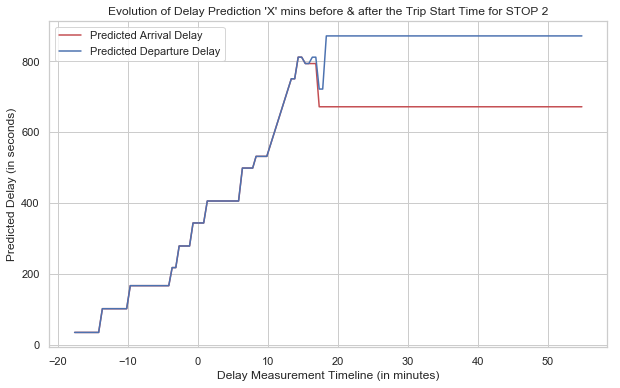

['2019-01-22 11:43:10', '2019-01-22 11:43:10', '2019-01-22 11:43:10', '2019-01-22 11:43:10', '2019-01-22 11:43:10', '2019-01-22 11:43:10', '2019-01-22 11:43:10', '2019-01-22 11:43:10', '2019-01-22 11:44:17', '2019-01-22 11:44:17', '2019-01-22 11:44:17', '2019-01-22 11:44:17', '2019-01-22 11:44:17', '2019-01-22 11:44:17', '2019-01-22 11:44:17', '2019-01-22 11:44:17', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:45:22', '2019-01-22 11:46:13', '2019-01-22 11:46:13', '2019-01-22 11:47:14', '2019-01-22 11:47:14', '2019-01-22 11:47:14', '2019-01-22 11:47:14', '2019-01-22 11:48:19', '2019-01-22 11:48:19', '2019-01-22 11:48:19', '2019-01-22 11:48:19', '2019-01-22 11:49:21', '2019-01-22 11:49:21', '2019-01-22 11:49:21', '2019-01-22 11:49:21', '2019-01-22 11:49:21', '2019-01-2

In [408]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(10,6))
# for cc in set(dataf[8]):
#     plt.plot(f_t[cc], a_d[cc])
#     plt.plot([x/60 for x in f_t[cc]], a_d[cc])
# plt.show()
i = 2
plt.plot([x/60 for x in f_t[i]], a_d[i], 'r', label='Predicted Arrival Delay')
plt.plot([x/60 for x in f_t[i]], d_d[i], 'b', label='Predicted Departure Delay')
plt.xlabel("Delay Measurement Timeline (in minutes)")
plt.ylabel("Predicted Delay (in seconds)")
plt.title("Evolution of Delay Prediction 'X' mins before & after the Trip Start Time for STOP " + str(i))
plt.legend()
plt.show()

print([datetime.utcfromtimestamp(int(ts)).strftime('%Y-%m-%d %H:%M:%S') for ts in a_t[i]])

In [324]:
qry3 = (" SELECT S.STOP_ID, S.STOP_NAME, COUNT(DISTINCT TRIP_ID)"
        " FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S"
        " WHERE TU.STOP_ID = S.STOP_ID"
        " AND UPPER(S.STOP_NAME) LIKE '%AMSTERDAM,%'"
        " GROUP BY S.STOP_ID"
        " ORDER BY S.STOP_ID;")

df3 = exec_query(qry3)

Connected to DB ... 128
exec_query() ... 
 SELECT S.STOP_ID, S.STOP_NAME, COUNT(DISTINCT TRIP_ID) FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S WHERE TU.STOP_ID = S.STOP_ID AND UPPER(S.STOP_NAME) LIKE '%AMSTERDAM,%' GROUP BY S.STOP_ID ORDER BY S.STOP_ID;
MySQL connection is closed


        0                            1   2
0  103851  Amsterdam, Station Lelylaan  45
1  103852  Amsterdam, Station Lelylaan  42
2  103904   Amsterdam, Heemstedestraat  36
3  103905   Amsterdam, Heemstedestraat  43
4  103914       Amsterdam, Rijksmuseum  40


C:\Users\kakka\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.04, 0.5, 'Number of Stops')

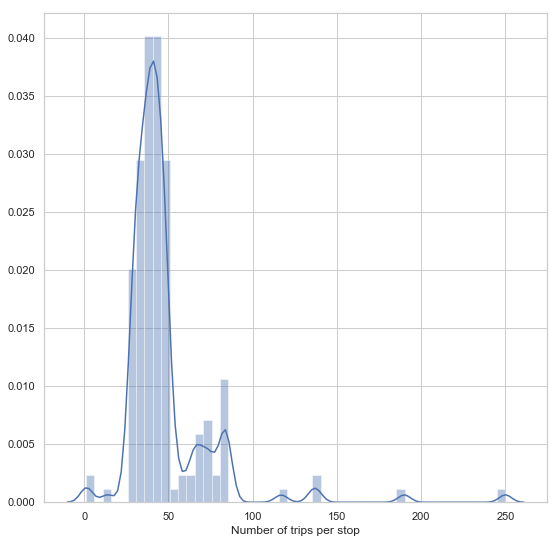

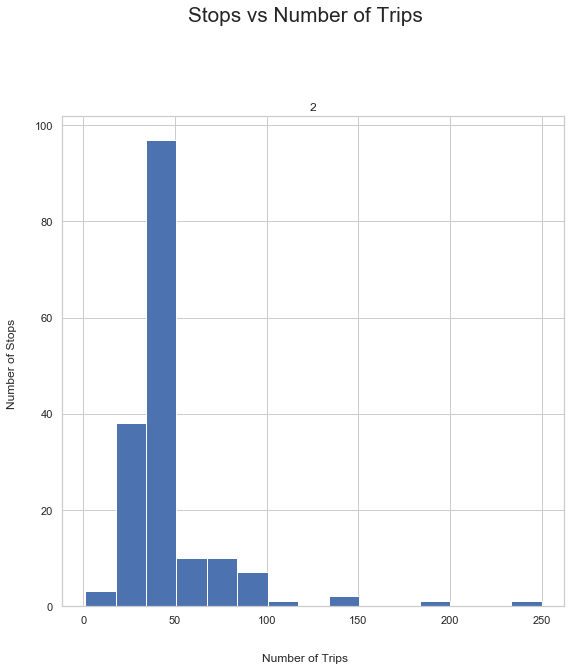

In [345]:
print(df3.head())

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(9, 9))
sns.distplot(df3[2], axlabel="Number of trips per stop")

# set up figure & axes
fig, axes = plt.subplots(figsize=(9, 9), nrows=1, ncols=1, sharex=True, sharey=True)

# drop sharex, sharey, layout & add ax=axes
df3.hist(bins=15, ax=axes)

# set title and axis labels
plt.suptitle('Stops vs Number of Trips', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Number of Trips', ha='center')
fig.text(0.04, 0.5, 'Number of Stops', va='center', rotation='vertical')

In [287]:
qry4 = (" SELECT S.STOP_ID, COUNT(DISTINCT TRIP_ID), MAX(ARRIVAL_DELAY), MIN(ARRIVAL_DELAY), AVG(ARRIVAL_DELAY),"
        " MAX(DEPARTURE_DELAY), MIN(DEPARTURE_DELAY), AVG(DEPARTURE_DELAY) "
        " FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S"
        " WHERE TU.STOP_ID = S.STOP_ID"
        " AND UPPER(S.STOP_NAME) LIKE '%AMSTERDAM,%'"
        " GROUP BY STOP_ID;")
df4 = exec_query(qry4)

Connected to DB ... 128
exec_query() ... 
 SELECT S.STOP_ID, COUNT(DISTINCT TRIP_ID), MAX(ARRIVAL_DELAY), MIN(ARRIVAL_DELAY), AVG(ARRIVAL_DELAY), MAX(DEPARTURE_DELAY), MIN(DEPARTURE_DELAY), AVG(DEPARTURE_DELAY)  FROM GTFS.TRIP_UPDATES TU, GTFS.STOPS S WHERE TU.STOP_ID = S.STOP_ID AND UPPER(S.STOP_NAME) LIKE '%AMSTERDAM,%' GROUP BY STOP_ID;
MySQL connection is closed


        0   1     2     3          4     5     6          7
0  103851  45   688 -5239  -999.0095   688 -5257  -990.7190
1  103852  42  1319 -4410  -842.2138  1319 -4428  -843.5926
2  103904  36  1039 -3897  -833.8880  1073 -3897  -797.4175
3  103905  43   994 -2035   -66.2290   994 -1956   -63.6143
4  103914  40  1912 -2850  -151.0388  1912 -2825  -138.3897


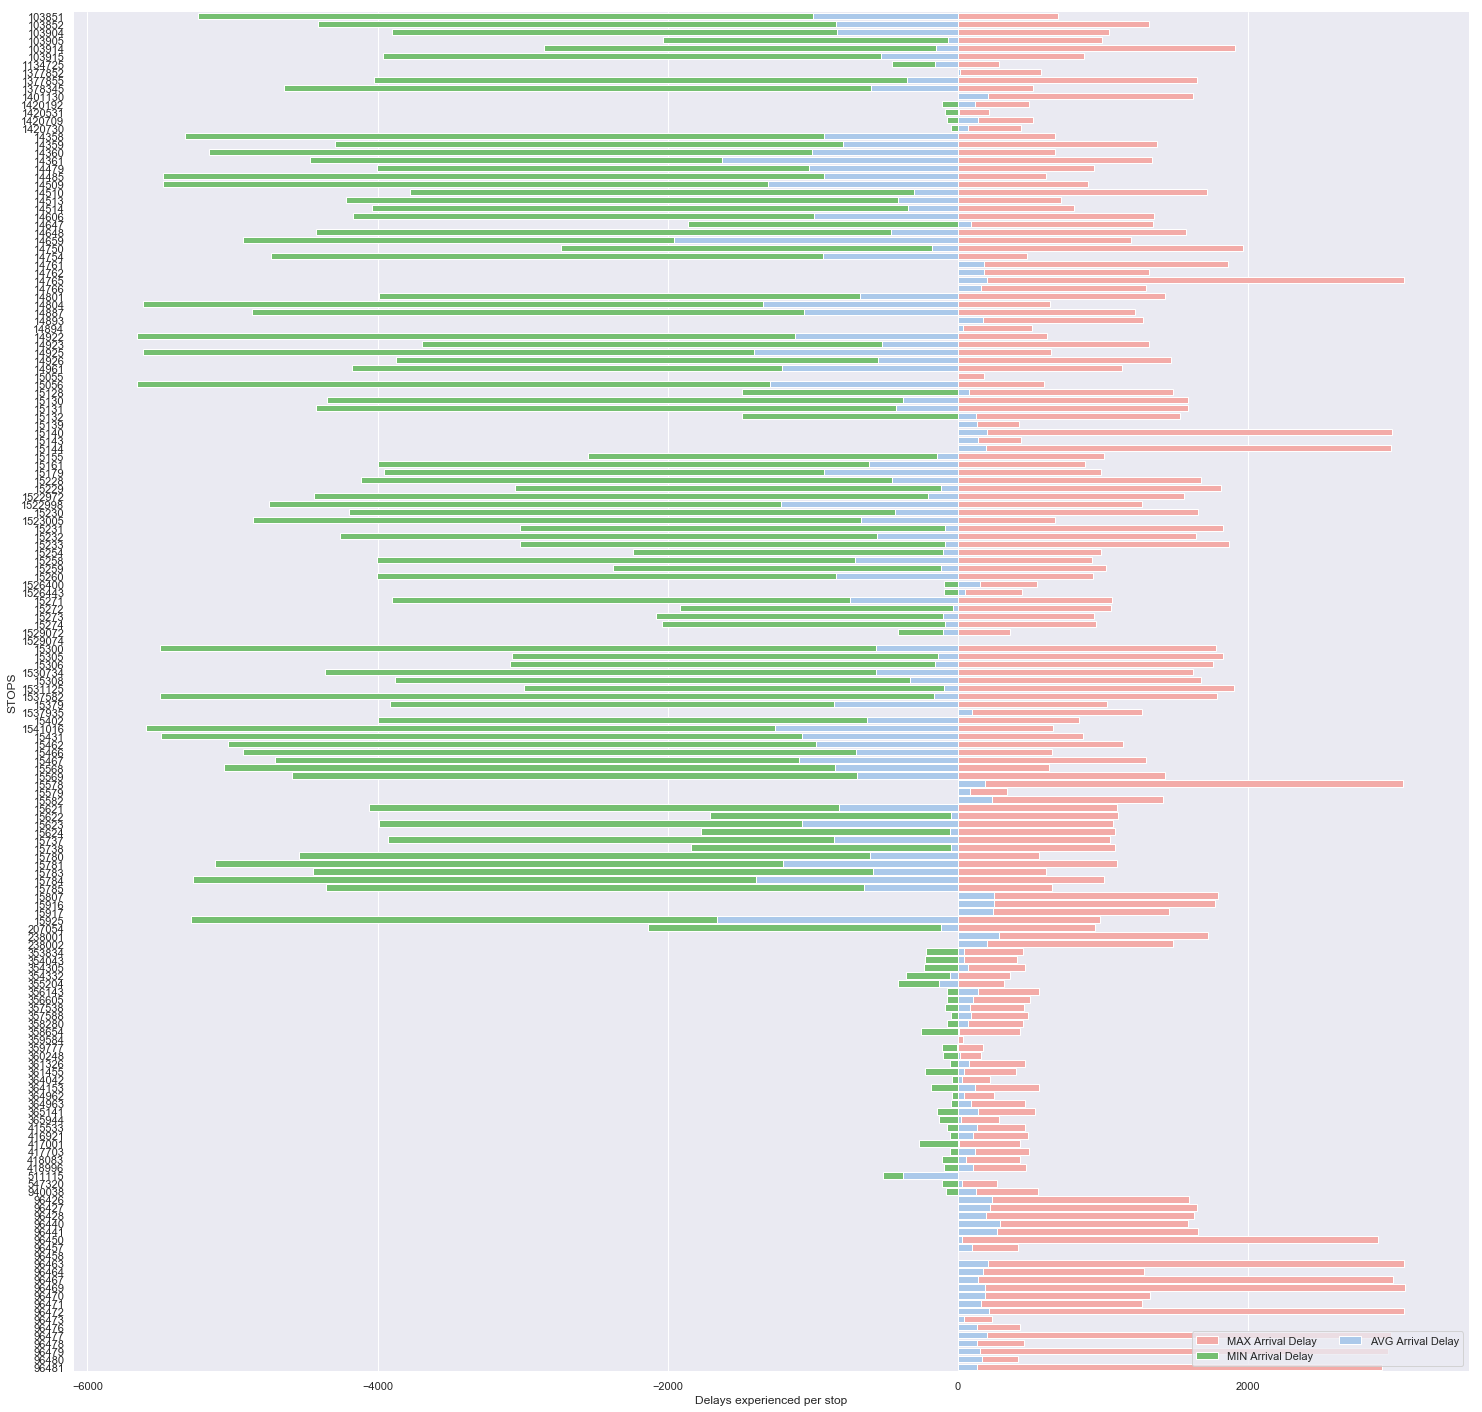

In [306]:
print(df4.head())
sns.set()

# print(sns.load_dataset("car_crashes").head())
fig, ax = plt.subplots(figsize=(25, 25))

sns.set_color_codes("pastel")
sns.barplot(x=2, y=0, data=df4, orient='h', label="MAX Arrival Delay", color="r")

sns.set_color_codes("muted")
sns.barplot(x=3, y=0, data=df4, orient='h', label="MIN Arrival Delay", color="g")

sns.set_color_codes("pastel")
sns.barplot(x=4, y=0, data=df4, orient='h', label="AVG Arrival Delay", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="STOPS", xlabel="Delays experienced per stop")
sns.despine(left=True, bottom=True)

        0   1     2     3          4     5     6          7
0  103851  45   688 -5239  -999.0095   688 -5257  -990.7190
1  103852  42  1319 -4410  -842.2138  1319 -4428  -843.5926
2  103904  36  1039 -3897  -833.8880  1073 -3897  -797.4175
3  103905  43   994 -2035   -66.2290   994 -1956   -63.6143
4  103914  40  1912 -2850  -151.0388  1912 -2825  -138.3897


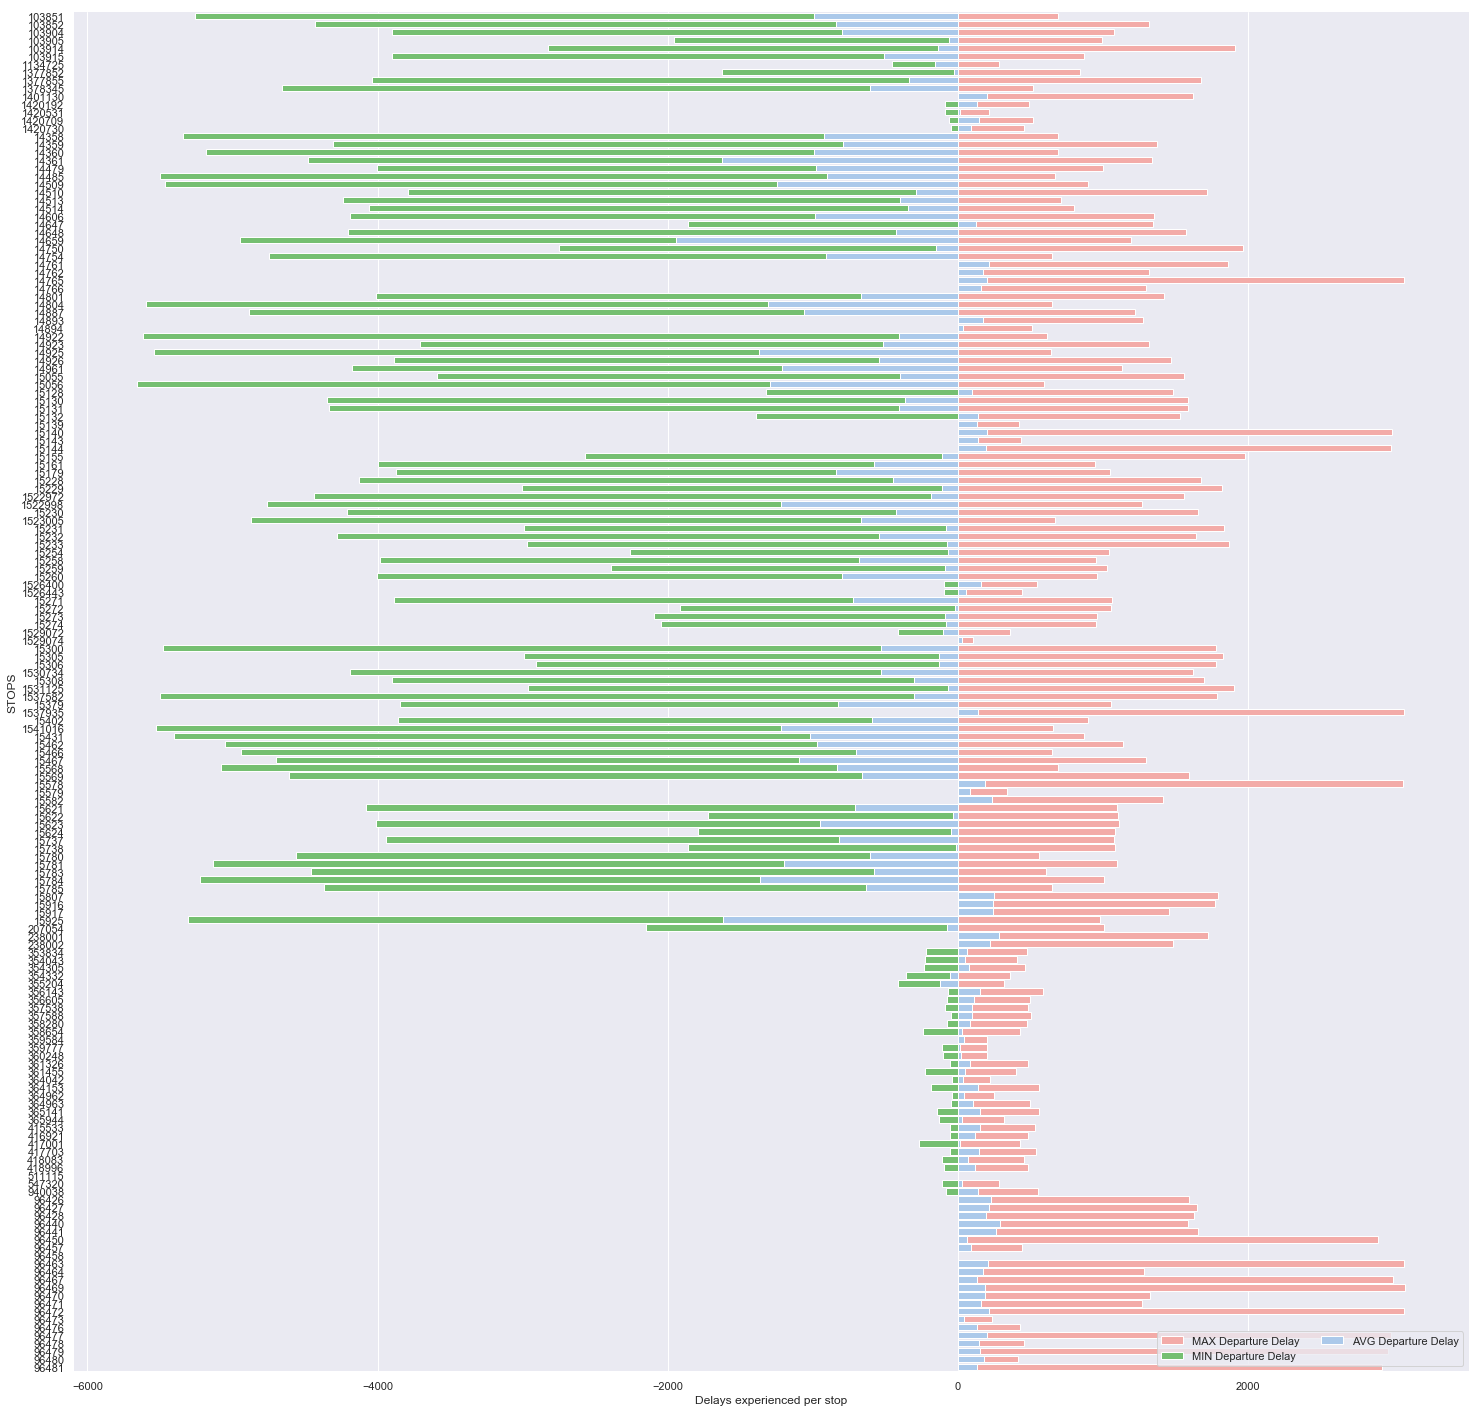

In [307]:
print(df4.head())
sns.set()

# print(sns.load_dataset("car_crashes").head())
fig, ax = plt.subplots(figsize=(25, 25))

sns.set_color_codes("pastel")
sns.barplot(x=5, y=0, data=df4, orient='h', label="MAX Departure Delay", color="r")

sns.set_color_codes("muted")
sns.barplot(x=6, y=0, data=df4, orient='h', label="MIN Departure Delay", color="g")

sns.set_color_codes("pastel")
sns.barplot(x=7, y=0, data=df4, orient='h', label="AVG Departure Delay", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="STOPS", xlabel="Delays experienced per stop")
sns.despine(left=True, bottom=True)

        0   1     2     3          4     5     6          7
0  103851  45   688 -5239  -999.0095   688 -5257  -990.7190
1  103852  42  1319 -4410  -842.2138  1319 -4428  -843.5926
2  103904  36  1039 -3897  -833.8880  1073 -3897  -797.4175
3  103905  43   994 -2035   -66.2290   994 -1956   -63.6143
4  103914  40  1912 -2850  -151.0388  1912 -2825  -138.3897


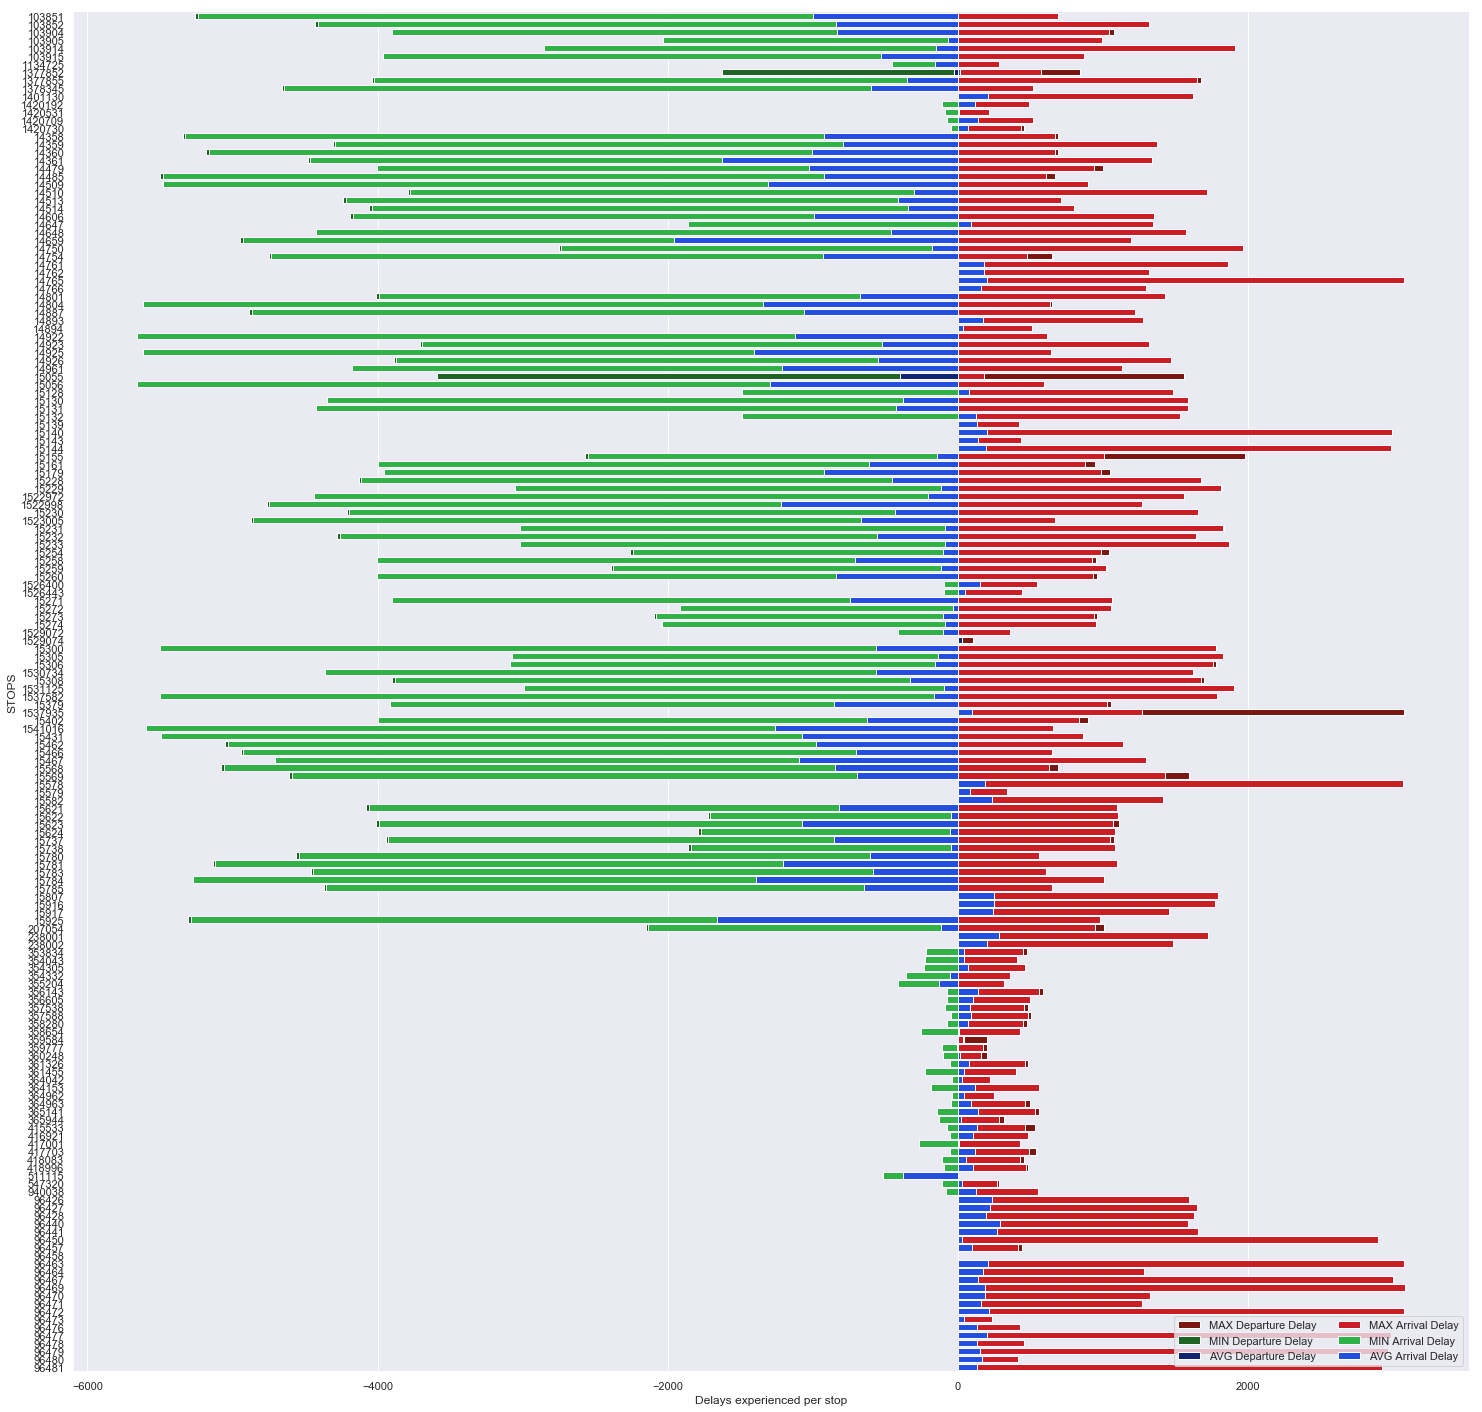

In [312]:
print(df4.head())
sns.set()

# print(sns.load_dataset("car_crashes").head())
fig, ax = plt.subplots(figsize=(25, 25))

sns.set_color_codes("dark")
sns.barplot(x=5, y=0, data=df4, orient='h', label="MAX Departure Delay", color="r")

sns.set_color_codes("dark")
sns.barplot(x=6, y=0, data=df4, orient='h', label="MIN Departure Delay", color="g")

sns.set_color_codes("dark")
sns.barplot(x=7, y=0, data=df4, orient='h', label="AVG Departure Delay", color="b")

sns.set_color_codes("bright")
sns.barplot(x=2, y=0, data=df4, orient='h', label="MAX Arrival Delay", color="r")

sns.set_color_codes("bright")
sns.barplot(x=3, y=0, data=df4, orient='h', label="MIN Arrival Delay", color="g")

sns.set_color_codes("bright")
sns.barplot(x=4, y=0, data=df4, orient='h', label="AVG Arrival Delay", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="STOPS", xlabel="Delays experienced per stop")
sns.despine(left=True, bottom=True)